# Example to use PyTorch Lightning with minimal code

# Steps
1. Install PyTorch Lightning
2. Define a LightningModule
3. Define a DataModule
4. Define Trainer
5. Train
6. Test
7. Save Model

# Step 0: Import useful module

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Install PyTorch Lightning

In [2]:
!pip install pytorch-lightning

## Step 2: Define a LightningModule
- The LightningModule have several function:
    - Define the network
    - Define the loss in every training/val/test step
    - Define the optimizer to be used
- And the module do all the remaining work automatically

In [3]:
import pytorch_lightning as pl

# For defining the network
import torch
from torch import nn
from torch.nn import functional as F

In [4]:
# seed everything for consistent results
pl.seed_everything(0)

Global seed set to 0


0

- Simple multi-layer perceptron for multi-class classification problem
    1. Flatten the input image
    2. Forward pass
    3. Predict the logit with log softmax layer
- Cross entropy loss
    - https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    - combined with log softmax layer, the final cross entropy loss will use negative log likelihood loss

In [5]:
class LitMLP(pl.LightningModule):

    def __init__(self,
                 in_dims,
                 n_layer_1=128,
                 n_layer_2=256,
                 n_classes=10,
                 lr=1e-4):

        super().__init__()

        # Define the Layer module used in the network
        self.layer_1 = nn.Linear(int(np.prod(in_dims)), n_layer_1)
        self.layer_2 = nn.Linear(n_layer_1, n_layer_2)
        self.layer_3 = nn.Linear(n_layer_2, n_classes)

        # Save arguments to hparams attribute.
        self.save_hyperparameters()

    def forward(self, x):

        batch_size, *dims = x.size()

        # Flatten
        x = x.view(batch_size, -1)

        # Forward pass
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)

        # log softmax layer to infer prob of each class
        x = F.log_softmax(x, dim=1)

        return x

    def loss(self, xs, ys):
        logits = self.forward(xs)
        loss = F.nll_loss(logits, ys)  # Negative log-likelihood loss nil_loss
        return logits, loss

    # Training step
    def training_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, dim=1)

        # logging metrics we calculated by hand
        self.log('train/loss', loss)
        return loss

     # Validation step
    def validation_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        self.log("val/loss", loss)  # default on val/test is on_epoch only
        return logits

    def test_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        self.log("test/loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

# Step 3: Define a Data Moduel
- Here we use MNIST as an example.
- We use DataLoader class from PyTorch.
- In DataLoader, we can specify num_workers to parallel the data fetching process

- Reference
    - https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/datamodules.html

In [6]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self,
                 data_dir = './data',
                 batch_size = 512,
                 num_workers = 16):
        super().__init__()

        self.data_dir = data_dir
        self.num_workers = num_workers

        self.mnist_train = None
        self.mnist_val = None
        self.mnist_test = None

        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        # download the dataset
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

# Step 5: Define Trainer
- We can use Callback to perform action in training. For example use for Early stopping

In [8]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [9]:
callbacks = [EarlyStopping(monitor="val/loss", mode="min", min_delta=0.001, patience=5, verbose=True)]

In [10]:
trainer = pl.Trainer(accelerator='gpu', devices=1,
                     max_epochs=-1,
                     deterministic=True,
                     callbacks=callbacks
                     )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Step 5: Train

In [11]:
model = LitMLP(in_dims=(28, 28))

In [12]:
# setup data
mnist = MNISTDataModule()
mnist.prepare_data()
mnist.setup()

In [13]:
trainer.fit(model=model, datamodule=mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 1.341


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.745 >= min_delta = 0.001. New best score: 0.596


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.169 >= min_delta = 0.001. New best score: 0.427


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.067 >= min_delta = 0.001. New best score: 0.361


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.035 >= min_delta = 0.001. New best score: 0.325


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.023 >= min_delta = 0.001. New best score: 0.302


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.001. New best score: 0.285


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.014 >= min_delta = 0.001. New best score: 0.271


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.001. New best score: 0.259


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.011 >= min_delta = 0.001. New best score: 0.248


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.001. New best score: 0.238


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.009 >= min_delta = 0.001. New best score: 0.230


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.001. New best score: 0.222


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.001. New best score: 0.214


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.001. New best score: 0.207


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.001. New best score: 0.201


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.001. New best score: 0.195


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.001. New best score: 0.190


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.185


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.180


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.175


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.171


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.167


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.163


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.159


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.156


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.153


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.150


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.147


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.144


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.141


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.139


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.136


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.134


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.132


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.129


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.127


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.125


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.123


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.122


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.120


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.118


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.117


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.115


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.114


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.112


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.111


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.109


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.107


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.106


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.105


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.104


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.102


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.101


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.099


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.098


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.096


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.095


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.094


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.093


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.092


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.090


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val/loss did not improve in the last 5 records. Best score: 0.090. Signaling Trainer to stop.


# Step 6: Test

In [14]:
# test the model
trainer.test(model, datamodule=mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.0810641273856163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.0810641273856163}]

# Step 7: Save Model
- In PyTorch Lightning format

In [15]:
trainer.save_checkpoint(filepath="./test_checkpoint.ckpt")

In [16]:
# Checkpoint is a Dict to store all the relevant information
type(torch.load("./test_checkpoint.ckpt"))

dict

In [17]:
new_model = LitMLP.load_from_checkpoint(checkpoint_path="./test_checkpoint.ckpt")

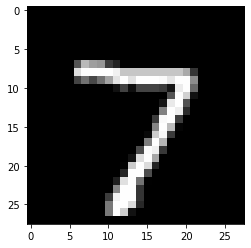

In [18]:
sample = next(iter(mnist.test_dataloader()))[0][0]
plt.imshow(sample[0], cmap="gray")

In [21]:
new_model.eval()
prediction = new_model(sample)
print(torch.exp(prediction))
print(torch.argmax(prediction, dim=1))

tensor([[1.0680e-06, 4.6415e-09, 1.2553e-05, 5.8883e-04, 8.9716e-09, 1.0829e-06,
         3.4664e-14, 9.9931e-01, 1.6537e-05, 6.6801e-05]],
       grad_fn=<ExpBackward0>)
tensor([7])
